In [2]:
from typing import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# NOTE: This data comes from wandb, so it's a bit weirdly structured.
df = pd.read_csv('../artifacts/csv-results/shot_influence.csv')

SHOTS = [0, 1, 2, 3]
LONG_SEQS = [7, 14, 23, 31]
LONG_SEQS_1024 = [4, 6]

# Extract and rename the columns we care about
selector_renamer = {
    **{f'deberta-base-for-{s}-shots-t-left-bs16*2-{s}sh-instance-split - eval/loss': f'{s}-shot-left-loss' for s in SHOTS},
    **{f'deberta-base-for-{s}-shots-t-left-bs16*2-{s}sh-instance-split - eval/roc_auc': f'{s}-shot-left-roc_auc' for s in SHOTS},
    **{f'deberta-base-for-{s}-shots-t-left-bs16*2-{s}sh-instance-split - eval/conf_absolute_roc_auc': f'{s}-shot-left-roc_auc-absolute-self' for s in SHOTS},
    **{f'deberta-base-for-{s}-shots-t-left-bs16*2-{s}sh-instance-split - eval/conf_normalized_roc_auc': f'{s}-shot-left-roc_auc-normalised-self' for s in SHOTS},
    **{f'deberta-base-for-{s}-shots-t-left-bs16*2-{s}sh-instance-split - eval/conf_distribution_roc_auc': f'{s}-shot-left-roc_auc-task-static' for s in SHOTS},
}
selector_renamer |= {k.replace('left', 'right'): v.replace('left', 'right') for k, v in selector_renamer.items()}
df = df.rename(columns=selector_renamer)[selector_renamer.values()] # type: ignore


# # Select the values with minimum loss for each shot count and truncation side
df = df.transpose()
def by_min_loss(row):
    shots, _, side, *_tail = row.name.split('-')
    name = f'{shots}-shot-{side}-loss'
    step = df.loc[name].idxmin()
    return row[step]
df = df.apply(by_min_loss, axis=1).to_frame()


df['shots'] = [int(s.split('-')[0]) for s in df.index]
df['truncation'] = ['left' if 'left' in s else 'right' for s in df.index]
df['metric'] = ['-'.join(s.split('-')[3:]) for s in df.index]
df.rename(columns={0: 'value'}, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head(10)

,value,shots,truncation,metric
0,0.527796,0,left,loss
1,0.555417,1,left,loss
2,0.558228,2,left,loss
3,0.573467,3,left,loss
4,0.775516,0,left,roc_auc
5,0.756348,1,left,roc_auc
6,0.758011,2,left,roc_auc
7,0.747830,3,left,roc_auc
8,0.486836,0,left,roc_auc-absolute-self
9,0.601690,1,left,roc_auc-absolute-self


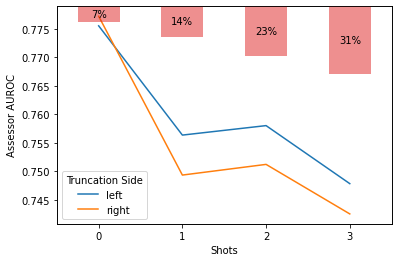

In [74]:
def plot(df: pd.DataFrame):
    df = df.rename(columns={'value': 'Assessor AUROC'})
    df = df.rename(columns={'shots': 'Shots'})
    df = df.rename(columns={'truncation': 'Truncation Side'})
    sns.lineplot(
        data=df.loc[(df.metric == 'roc_auc')], 
        x='Shots', y='Assessor AUROC', 
        hue='Truncation Side',
        markers=True,
        dashes=False
    )
    plt.legend(loc='lower left', title='Truncation Side')
    ax2 = plt.twinx()
    sns.barplot(x=[0,1,2,3], y=[-v for v in LONG_SEQS], color='red', alpha=0.5, ax=ax2, width=0.5)
    ax2.set_ylim(-100, 0)
    # plt.yticks(np.linspace(-100, 0, 5), labels=[f'{v}%' for v in np.linspace(0, 100, 5)][::-1])
    plt.yticks([])

    for container in ax2.containers:
        ax2.bar_label(container, labels=[f"{v}%" for v in LONG_SEQS], label_type='center')

    # df = df.rename(columns={'Assessor AUROC': 'Normalised-Self AUROC'})
    # sns.lineplot(
    #     data=df.loc[(df.metric == 'roc_auc-normalised-self') & (df['Truncation Side'] == 'left')], 
    #     x='Shots', y='Normalised-Self AUROC', 
    #     markers=True,
    #     dashes=False,
    #     ax=ax2,
    # )

    # TODO: Add percent of instances too long?
    plt.xticks(SHOTS)

plot(df)